In [1]:
from datetime import datetime
import datetime as dt
import os
from operator import itemgetter
import shutil 
import pickle
import time
import json

from django.contrib.gis.geos.geometry import GEOSGeometry
from osgeo import osr
from pyproj import Proj
from fiona.crs import from_epsg
from sklearn.cluster import KMeans
import geopandas as gpd
from affine import Affine
import xarray as xr
import numpy as np
from rasterio.features import rasterize
import fiona
import glob
from dask.distributed import Client
from datacube.drivers.netcdf import write_dataset_to_netcdf
from datacube.api import GridWorkflow

from madmex.wrappers import gwf_query
from madmex.util.xarray import to_float, to_int
from madmex.models import PredictObject, TrainClassification


2020-02-13 20:37:55,157 - datacube.drivers.driver_cache - driver_cache safe_load: Failed to resolve driver datacube.plugins.index::s3aio_index
2020-02-13 20:37:55,159 - datacube.drivers.driver_cache - driver_cache safe_load: Error was: UndefinedEnvironmentName("'extra' does not exist in evaluation environment.",)


In [2]:
client = Client(n_workers=5,memory_limit='110GB', threads_per_worker=1)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:38643 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 5 Memory: 550.00 GB


In [4]:
client.restart()

Client Scheduler: tcp://127.0.0.1:38643 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 5 Memory: 550.00 GB


In [5]:
region = 'cultivos_2019_simplify'
name_of_product = 's2_l2a_10m_scl_mexico'
begin = '2018-01-01'
end = '2019-12-31'
gwf_kwargs = {'region': region, 'product': name_of_product, 'begin': begin, 'end':end}
iterable = gwf_query(**gwf_kwargs)

In [6]:
lista_iter = list(iterable)

In [7]:
[lista_iter[x][0] for x in range(0,len(lista_iter))]

[(47, -35),
 (47, -37),
 (48, -37),
 (47, -36),
 (48, -36),
 (40, -31),
 (39, -31),
 (38, -30),
 (39, -30),
 (40, -30),
 (39, -29),
 (38, -29),
 (40, -29),
 (38, -28),
 (40, -28),
 (38, -27),
 (39, -28),
 (39, -27),
 (38, -26),
 (39, -26),
 (40, -33),
 (40, -32),
 (39, -32),
 (37, -29),
 (40, -34),
 (41, -33),
 (42, -33),
 (41, -32),
 (42, -32),
 (41, -31),
 (42, -31),
 (43, -33),
 (44, -34),
 (43, -35),
 (45, -34),
 (44, -35),
 (45, -37),
 (43, -34),
 (44, -37),
 (43, -36),
 (45, -36),
 (45, -35),
 (44, -36),
 (42, -34),
 (41, -34),
 (37, -27),
 (37, -26),
 (37, -28),
 (41, -30),
 (46, -35),
 (46, -34),
 (46, -36),
 (46, -37)]

In [8]:
len(lista_iter)

53

# 1) Se elige el primer dc_tile de lista_iter para la generación de segmentos clusterizados

In [9]:
date_today = datetime.today().strftime("%m-%d-%Y")

In [10]:
date_today

'02-13-2020'

In [11]:
index=0

In [12]:
var=lista_iter[0]

In [13]:
dc_tile = '%d_%d' % (var[0][0], var[0][1])

In [14]:
dc_tile

'47_-35'

In [15]:
var

((47, -35), Tile<sources=<xarray.DataArray (time: 219)>
 array([(Dataset <id=5de2d079-c854-428a-b241-b92640253350 type=s2_l2a_10m_scl_mexico location=file:///shared_volume/datacube/datacube_ingest/s2_l2a_10m_scl_s3/mexico/s2_l2a_10m_scl_s3_47_-35_20181005164324000000.nc>,),
        (Dataset <id=193ffac0-c34a-400e-9d84-0a6f5c1d6f61 type=s2_l2a_10m_scl_mexico location=file:///shared_volume/datacube/datacube_ingest/s2_l2a_10m_scl_s3/mexico/s2_l2a_10m_scl_s3_47_-35_20181010164609000000.nc>,),
        (Dataset <id=7c9731e5-e48e-4e04-a0f9-41d62c5d0111 type=s2_l2a_10m_scl_mexico location=file:///shared_volume/datacube/datacube_ingest/s2_l2a_10m_scl_s3/mexico/s2_l2a_10m_scl_s3_47_-35_20181013164842000000.nc>,),
        (Dataset <id=beb5f46f-8c9b-47dc-ac87-9d20a7894bf4 type=s2_l2a_10m_scl_mexico location=file:///shared_volume/datacube/datacube_ingest/s2_l2a_10m_scl_s3/mexico/s2_l2a_10m_scl_s3_47_-35_20181015163720000000.nc>,),
        (Dataset <id=3ad7101b-c785-450f-9703-e6265f2e0542 type=s2_l2

In [16]:
sr_0 = GridWorkflow.load(var[1],dask_chunks={'x': 1600, 'y': 1600,'time': 60})

In [17]:
sr_0

<xarray.Dataset>
Dimensions:   (time: 219, x: 5002, y: 5002)
Coordinates:
  * time      (time) datetime64[ns] 2018-10-05T16:43:24 ... 2019-09-25T16:48:37.510000
  * y         (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x         (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
Data variables:
    blue      (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    green     (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    red       (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    nir       (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    pixel_qa  (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...

In [18]:
sr_0

<xarray.Dataset>
Dimensions:   (time: 219, x: 5002, y: 5002)
Coordinates:
  * time      (time) datetime64[ns] 2018-10-05T16:43:24 ... 2019-09-25T16:48:37.510000
  * y         (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x         (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
Data variables:
    blue      (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    green     (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    red       (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    nir       (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    pixel_qa  (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...

In [19]:
#crs = var[1].geobox.crs

In [20]:
sr_0.attrs['geobox'] = var[1].geobox

In [21]:
sr_0 = client.persist(sr_0)

**110gb is enough**

In [22]:
sr_0

<xarray.Dataset>
Dimensions:   (time: 219, x: 5002, y: 5002)
Coordinates:
  * time      (time) datetime64[ns] 2018-10-05T16:43:24 ... 2019-09-25T16:48:37.510000
  * y         (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x         (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
Data variables:
    blue      (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    green     (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    red       (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    nir       (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    pixel_qa  (time, y, x) uint16 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...
    geobox:   GeoBox(Geometry({'type': 'Polygon', 'coordinates': [[(-94.15122...

In [23]:
sr_0 = sr_0.apply(func=to_float, keep_attrs=True)

In [24]:
sr_1 = sr_0.where(sr_0.pixel_qa.isin([2,4,5,6,7,8,11]))

In [25]:
sr_1['ndvi'] = ((sr_1.nir - sr_1.red) / (sr_1.nir + sr_1.red)) * 10000

In [26]:
sr_1['ndvi'].attrs['nodata'] = 0

In [27]:
sr_1

<xarray.Dataset>
Dimensions:   (time: 219, x: 5002, y: 5002)
Coordinates:
  * time      (time) datetime64[ns] 2018-10-05T16:43:24 ... 2019-09-25T16:48:37.510000
  * y         (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x         (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
Data variables:
    blue      (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    green     (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    red       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    nir       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    pixel_qa  (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    ndvi      (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...
    geobox:   GeoBox(Geometry({'type': 'Polygon', 'coordinates': [[(-94.15122...

In [28]:
sr_1['gndvi'] = ((sr_1.nir - sr_1.green) / (sr_1.nir + sr_1.green)) * 10000

In [29]:
sr_1['gndvi'].attrs['nodata'] = 0

In [30]:
sr_1

<xarray.Dataset>
Dimensions:   (time: 219, x: 5002, y: 5002)
Coordinates:
  * time      (time) datetime64[ns] 2018-10-05T16:43:24 ... 2019-09-25T16:48:37.510000
  * y         (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x         (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
Data variables:
    blue      (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    green     (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    red       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    nir       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    pixel_qa  (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    ndvi      (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    gndvi     (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...
    geobox:   GeoBox(Geometry({'type': 'Polygon', 'coordinates': [[(-94.15122...

In [31]:
sr_1['avi'] = ((sr_1.nir*(1-sr_1.red))*(sr_1.nir-sr_1.red))**(1/3)

In [32]:
sr_1['avi'].attrs['nodata'] = 0

In [33]:
sr_1

<xarray.Dataset>
Dimensions:   (time: 219, x: 5002, y: 5002)
Coordinates:
  * time      (time) datetime64[ns] 2018-10-05T16:43:24 ... 2019-09-25T16:48:37.510000
  * y         (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x         (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
Data variables:
    blue      (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    green     (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    red       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    nir       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    pixel_qa  (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    ndvi      (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    gndvi     (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    avi       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...
    geobox:   GeoBox(Geometry({'type': 'Polygon', 'coordinates': [[(-94.15122...

In [34]:
sr_1 = client.persist(sr_1)

In [35]:
sr_1

<xarray.Dataset>
Dimensions:   (time: 219, x: 5002, y: 5002)
Coordinates:
  * time      (time) datetime64[ns] 2018-10-05T16:43:24 ... 2019-09-25T16:48:37.510000
  * y         (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x         (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
Data variables:
    blue      (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    green     (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    red       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    nir       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    pixel_qa  (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    ndvi      (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    gndvi     (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    avi       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...
    geobox:   GeoBox(Geometry({'type': 'Polygon', 'coordinates': [[(-94.15122...

# 2) Cálculo de features por ejemplo el máximo, mínimo del NDVI en toda la serie de tiempo y el promedio NDVI de forma mensual

In [36]:
times = np.datetime_as_string(sr_1.time.values,unit='D')

In [37]:
times_datetime = [datetime.strptime(x,'%Y-%m-%d') for x in times]

In [38]:
times_months = [str(d.month) for d in times_datetime]

In [39]:
from collections import Counter

In [40]:
Counter(times_months)

Counter({'10': 9,
         '11': 16,
         '12': 15,
         '1': 20,
         '2': 18,
         '3': 19,
         '4': 22,
         '5': 29,
         '6': 19,
         '7': 23,
         '8': 19,
         '9': 10})

In [41]:
sr_1.ndvi

<xarray.DataArray 'ndvi' (time: 219, y: 5002, x: 5002)>
dask.array<mul, shape=(219, 5002, 5002), dtype=float64, chunksize=(60, 1600, 1600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-10-05T16:43:24 ... 2019-09-25T16:48:37.510000
  * y        (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x        (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
Attributes:
    nodata:   0

In [42]:
#time_window = int((np.max([num for num in Counter(times_months).values()])-
#                  np.min([num for num in Counter(times_months).values()]))/2)

In [43]:
#time_window = int((np.median([num for num in Counter(times_months).values()])))

In [44]:
#time_window = np.min([num for num in Counter(times_months).values()])

In [45]:
#time_window =3
#ndvi_mean = sr_1.ndvi.rolling(time=time_window,min_periods=time_window,center=True).mean(keep_attrs=True)
#ndvi_mean = client.persist(ndvi_mean)
#ndvi_mean_drop_na = ndvi_mean.dropna('time',how='all')
#times=np.datetime_as_string(ndvi_mean.time.values,unit='D')
#times=[datetime.strptime(x,'%Y-%m-%d') for x in times]
#ndvi_mean_times_clean = ndvi_mean.assign_coords({'time':times})
#ndvi_mean_times_clean.attrs['nodata'] = 0
#ndvi_mean_times_clean = ndvi_mean_times_clean.rename('ndvi_window_mean')
#ndvi_max = sr_1.ndvi.rolling(time=time_window,min_periods=time_window).max(keep_attrs=True)
#ndvi_max =client.persist(ndvi_max)
#ndvi_max_drop_na = ndvi_max.dropna('time',how='all')
#ndvi_max_times_clean = ndvi_max.assign_coords({'time':times})
#ndvi_max_times_clean.attrs['nodata'] = 0
#ndvi_max_times_clean = ndvi_max_times_clean.rename('ndvi_window_max')
#ndvi_min = sr_1.ndvi.rolling(time=time_window,min_periods=time_window).min(keep_attrs=True)
#ndvi_min = client.persist(ndvi_min)
#ndvi_min_drop_na = ndvi_min.dropna('time',how='all')
#ndvi_min_times_clean = ndvi_min.assign_coords({'time':times})
#ndvi_min_times_clean.attrs['nodata'] = 0
#ndvi_min_times_clean = ndvi_min_times_clean.rename('ndvi_window_min')

In [46]:
ndvi_mean_resampled = sr_1.ndvi.resample(time='M').mean()

In [47]:
ndvi_mean_resampled

<xarray.DataArray 'ndvi' (time: 12, y: 5002, x: 5002)>
dask.array<stack, shape=(12, 5002, 5002), dtype=float64, chunksize=(1, 1600, 1600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-10-31 2018-11-30 ... 2019-09-30
  * y        (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x        (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06

In [48]:
ndvi_mean_resampled = client.persist(ndvi_mean_resampled)

In [49]:
ndvi_mean_resampled

<xarray.DataArray 'ndvi' (time: 12, y: 5002, x: 5002)>
dask.array<stack, shape=(12, 5002, 5002), dtype=float64, chunksize=(1, 1600, 1600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-10-31 2018-11-30 ... 2019-09-30
  * y        (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x        (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06

In [50]:
ndvi_mean_resampled_drop_na = ndvi_mean_resampled.dropna('time',how='all')

In [51]:
ndvi_mean_resampled_drop_na

<xarray.DataArray 'ndvi' (time: 12, y: 5002, x: 5002)>
dask.array<getitem, shape=(12, 5002, 5002), dtype=float64, chunksize=(1, 1600, 1600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-10-31 2018-11-30 ... 2019-09-30
  * y        (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x        (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06

In [52]:
len(sr_1.time.values)

219

In [53]:
len(ndvi_mean_resampled_drop_na.time.values)

12

In [54]:
#times=np.datetime_as_string(ndvi_mean_resampled_drop_na.time.values,unit='D')

In [55]:
#times

In [56]:
#times=[datetime.strptime(x,'%Y-%m-%d') for x in times]

In [57]:
#len(times)

In [58]:
#ndvi_mean_resampled_times_clean = ndvi_mean_resampled_drop_na.assign_coords({'time':times})
#ndvi_mean_resampled_times_clean.attrs['nodata'] = 0
#ndvi_mean_resampled_times_clean = ndvi_mean_resampled_times_clean.rename('ndvi_mean_resampled')

In [59]:
#ndvi_mean_resampled_times_clean

In [60]:
#ndvi_mean_resampled_times_clean.time.values

In [61]:
sr_1

<xarray.Dataset>
Dimensions:   (time: 219, x: 5002, y: 5002)
Coordinates:
  * time      (time) datetime64[ns] 2018-10-05T16:43:24 ... 2019-09-25T16:48:37.510000
  * y         (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x         (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
Data variables:
    blue      (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    green     (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    red       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    nir       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    pixel_qa  (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    ndvi      (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    gndvi     (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
    avi       (time, y, x) float64 dask.array<chunksize=(60, 1600, 1600), meta=np.ndarray>
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...
    geobox:   GeoBox(Geometry({'type': 'Polygon', 'coordinates': [[(-94.15122...

In [62]:
gndvi_mean_resampled = sr_1.gndvi.resample(time='M').mean()

In [63]:
gndvi_mean_resampled = client.persist(gndvi_mean_resampled)

In [64]:
gndvi_mean_resampled_drop_na = gndvi_mean_resampled.dropna('time',how='all')

In [65]:
#ndvi_max_resampled_times_clean = ndvi_max_resampled_drop_na.assign_coords({'time':times})
#ndvi_max_resampled_times_clean.attrs['nodata'] = 0
#ndvi_max_resampled_times_clean = ndvi_max_resampled_times_clean.rename('ndvi_max_resampled')

In [66]:
#ndvi_max_resampled_times_clean

In [67]:
avi_mean_resampled = sr_1.avi.resample(time='M').mean()

In [68]:
avi_mean_resampled = client.persist(avi_mean_resampled)

In [69]:
avi_mean_resampled_drop_na = avi_mean_resampled.dropna('time',how='all')

In [70]:
#ndvi_min_resampled_times_clean = ndvi_min_resampled_drop_na.assign_coords({'time':times})
#ndvi_min_resampled_times_clean.attrs['nodata'] = 0
#ndvi_min_resampled_times_clean = ndvi_min_resampled_times_clean.rename('ndvi_min_resampled')

In [71]:
#ndvi_min_resampled_times_clean

In [72]:
sr_0.geobox

GeoBox(5002, 5002, Affine(10.0, 0.0, 3328100.0,
       0.0, -10.0, 726040.0), PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS84",6378137,6556752.3141]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["latitude_of_origin",12],PARAMETER["central_meridian",-102],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0]])

**check next lines to compute median, percentiles in the future**

In [73]:
#import dask.array as da

In [74]:
#ndvi_min_nan = da.nanmin(sr_1.ndvi, axis=0)

In [75]:
#ndvi_min_nan

In [76]:
#ndvi_min_nan = client.persist(ndvi_min_nan)

In [77]:
#ndvi_min_nan

In [78]:
#ndvi_median = sr_1.ndvi.median('time', keep_attrs=True, skipna=True)

In [79]:
#ndvi_median = client.persist(ndvi_median)

In [80]:
#ndvi_median

In [81]:
#ndvi_median = ndvi_median.rename('ndvi_median')
#ndvi_median.attrs['nodata'] = 0

In [82]:
#ndvi_median

In [83]:
combined = xr.merge([ndvi_mean_resampled_drop_na,
                     gndvi_mean_resampled_drop_na,
                     avi_mean_resampled_drop_na])

In [84]:
combined

<xarray.Dataset>
Dimensions:  (time: 12, x: 5002, y: 5002)
Coordinates:
  * time     (time) datetime64[ns] 2018-10-31 2018-11-30 ... 2019-09-30
  * y        (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x        (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
Data variables:
    ndvi     (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    gndvi    (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    avi      (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>

In [85]:
combined.data_vars

Data variables:
    ndvi     (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    gndvi    (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    avi      (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>

In [86]:
combined = client.persist(combined)

In [87]:
combined

<xarray.Dataset>
Dimensions:  (time: 12, x: 5002, y: 5002)
Coordinates:
  * time     (time) datetime64[ns] 2018-10-31 2018-11-30 ... 2019-09-30
  * y        (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * x        (x) float64 3.328e+06 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
Data variables:
    ndvi     (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    gndvi    (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    avi      (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>

In [88]:
features = list(combined.data_vars)
s = '-'
features_string = s.join(features)

In [89]:
features_string

'ndvi-gndvi-avi'

In [90]:
path_result = '/LUSTRE/MADMEX/tasks/2020/1_clusterization_for_agriculture_labeling/features_computed/' + features_string + '/'

In [91]:
path_result_dc_tile = os.path.join(path_result, date_today 
                                   + '/' + dc_tile + '/')

In [92]:
path_result_dc_tile

'/LUSTRE/MADMEX/tasks/2020/1_clusterization_for_agriculture_labeling/features_computed/ndvi-gndvi-avi/02-13-2020/47_-35/'

In [93]:
if not os.path.exists(path_result_dc_tile):
    os.makedirs(path_result_dc_tile)

In [94]:
nc_filename = path_result_dc_tile + date_today + '_combined_' + dc_tile + '.nc'

In [95]:
nc_filename

'/LUSTRE/MADMEX/tasks/2020/1_clusterization_for_agriculture_labeling/features_computed/ndvi-gndvi-avi/02-13-2020/47_-35/02-13-2020_combined_47_-35.nc'

In [96]:
#combined.attrs['crs'] = crs

In [97]:
combined.attrs = sr_0.attrs

In [98]:
combined.coords['time'].attrs = sr_0.coords['time'].attrs
combined.coords['x'].attrs = sr_0.coords['x'].attrs
combined.coords['y'].attrs = sr_0.coords['y'].attrs

In [111]:
write_dataset_to_netcdf(combined.compute(),nc_filename)

# 3) Leer segmentación

In [353]:
geom = GEOSGeometry(json.dumps(sr_0.geobox.geographic_extent.json))

In [354]:
seg_name = 'seg_mex_s2_10m_scl_2018_2019'

In [355]:
qs = PredictObject.objects.filter(the_geom__contained=geom,segmentation_information__name=seg_name)

In [356]:
path_seg = qs[0].path

In [104]:
path_seg

'/shared_volume/segmentation_antares3_results/bis_seg_mex_s2_10m_scl_2018_2019_sentinel_2_47_-35_2018_2019.shp'

In [105]:
from fiona.crs import to_string

In [106]:
with fiona.open(path_seg) as src:
    fc = list(src)
    crs = to_string(src.crs)

In [107]:
fc_subset=((x['properties']['id'], x['geometry']) for x in fc)

In [108]:
fc_sorted = sorted(fc_subset, key=itemgetter(0))

In [109]:
fc_sorted[0]

(0,
 {'type': 'Polygon',
  'coordinates': [[(3328220.0, 676150.0),
    (3328240.0, 676150.0),
    (3328240.0, 676140.0),
    (3328230.0, 676140.0),
    (3328230.0, 676130.0),
    (3328240.0, 676130.0),
    (3328240.0, 676120.0),
    (3328260.0, 676120.0),
    (3328260.0, 676100.0),
    (3328270.0, 676100.0),
    (3328270.0, 676080.0),
    (3328260.0, 676080.0),
    (3328230.0, 676080.0),
    (3328230.0, 676050.0),
    (3328220.0, 676050.0),
    (3328210.0, 676050.0),
    (3328210.0, 676030.0),
    (3328220.0, 676030.0),
    (3328220.0, 676020.0),
    (3328190.0, 676020.0),
    (3328190.0, 676040.0),
    (3328160.0, 676040.0),
    (3328160.0, 676060.0),
    (3328170.0, 676060.0),
    (3328170.0, 676070.0),
    (3328150.0, 676070.0),
    (3328150.0, 676050.0),
    (3328140.0, 676050.0),
    (3328120.0, 676050.0),
    (3328120.0, 676030.0),
    (3328110.0, 676030.0),
    (3328110.0, 676020.0),
    (3328100.0, 676020.0),
    (3328100.0, 676120.0),
    (3328110.0, 676120.0),
    (3328110.0,

In [110]:
len([k[0] for k in fc_sorted])

451947

**First position of fc_sorted is id, second position is geometry**


In [111]:
iterable_zip = zip([k[1] for k in fc_sorted], [k[0] for k in fc_sorted])

In [112]:
sr_0.affine

Affine(10.0, 0.0, 3328100.0,
       0.0, -10.0, 726040.0)

In [113]:
list(sr_0.affine)

[10.0, 0.0, 3328100.0, 0.0, -10.0, 726040.0, 0.0, 0.0, 1.0]

In [114]:
list(sr_0.affine)[0:6]

[10.0, 0.0, 3328100.0, 0.0, -10.0, 726040.0]

In [115]:
aff = Affine(*list(sr_0.affine)[0:6])

In [116]:
dimensions_dataset = list(sr_0.coords)
list_dimensions = [x for x in dimensions_dataset if x != 'time']
lambda_function = lambda l_netcdf,l_test: l_netcdf[0] if l_netcdf[0] in l_test else l_netcdf[1]
xdim = lambda_function(list_dimensions,['x','longitude'])
ydim = lambda_function(list_dimensions,['y','latitude'])

In [117]:
fc_raster = rasterize(iterable_zip, transform=aff,
                      out_shape=(sr_0.sizes[ydim], sr_0.sizes[xdim]),
                      dtype='float64', fill=np.nan)

In [118]:
fc_raster

array([[4.50564e+05, 4.50564e+05, 4.50564e+05, ..., 4.51910e+05,
        4.51910e+05, 4.51910e+05],
       [4.50564e+05, 4.50564e+05, 4.50564e+05, ..., 4.51910e+05,
        4.51910e+05, 4.51910e+05],
       [4.50564e+05, 4.50564e+05, 4.50564e+05, ..., 4.51540e+05,
        4.51540e+05, 4.51910e+05],
       ...,
       [0.00000e+00, 0.00000e+00, 2.00000e+00, ..., 7.02000e+02,
        7.03000e+02, 7.03000e+02],
       [0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 7.02000e+02,
        7.03000e+02, 7.03000e+02],
       [0.00000e+00, 1.00000e+00, 1.00000e+00, ..., 7.02000e+02,
        7.03000e+02, 7.03000e+02]])

In [119]:
fc_raster = fc_raster.astype(int)

In [120]:
fc_raster

array([[450564, 450564, 450564, ..., 451910, 451910, 451910],
       [450564, 450564, 450564, ..., 451910, 451910, 451910],
       [450564, 450564, 450564, ..., 451540, 451540, 451910],
       ...,
       [     0,      0,      2, ...,    702,    703,    703],
       [     0,      0,      1, ...,    702,    703,    703],
       [     0,      1,      1, ...,    702,    703,    703]])

In [121]:
fc_dataarray = xr.DataArray(fc_raster, dims=[ydim, xdim], name='features_id')

In [122]:
fc_dataarray

<xarray.DataArray 'features_id' (y: 5002, x: 5002)>
array([[450564, 450564, 450564, ..., 451910, 451910, 451910],
       [450564, 450564, 450564, ..., 451910, 451910, 451910],
       [450564, 450564, 450564, ..., 451540, 451540, 451910],
       ...,
       [     0,      0,      2, ...,    702,    703,    703],
       [     0,      0,      1, ...,    702,    703,    703],
       [     0,      1,      1, ...,    702,    703,    703]])
Dimensions without coordinates: y, x

# 4) Construcción de dataframes para pasar al kmeans

In [123]:
combined = xr.merge([fc_dataarray,combined])

In [124]:
combined

<xarray.Dataset>
Dimensions:      (time: 12, x: 5002, y: 5002)
Coordinates:
  * x            (x) float64 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
  * y            (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * time         (time) datetime64[ns] 2018-10-31 2018-11-30 ... 2019-09-30
Data variables:
    features_id  (y, x) int64 450564 450564 450564 450564 ... 702 702 703 703
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    gndvi        (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    avi          (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>

In [125]:
combined = client.persist(combined)

In [126]:
combined

<xarray.Dataset>
Dimensions:      (time: 12, x: 5002, y: 5002)
Coordinates:
  * x            (x) float64 3.328e+06 3.328e+06 ... 3.378e+06 3.378e+06
  * y            (y) float64 7.26e+05 7.26e+05 7.26e+05 ... 6.76e+05 6.76e+05
  * time         (time) datetime64[ns] 2018-10-31 2018-11-30 ... 2019-09-30
Data variables:
    features_id  (y, x) int64 450564 450564 450564 450564 ... 702 702 703 703
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    gndvi        (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    avi          (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>

In [127]:
combined = combined.stack(z=(xdim, ydim))
combined = combined.reset_index('z')
combined = combined.drop([xdim,ydim])


In [128]:
combined

<xarray.Dataset>
Dimensions:      (time: 12, z: 25020004)
Coordinates:
  * time         (time) datetime64[ns] 2018-10-31 2018-11-30 ... 2019-09-30
Dimensions without coordinates: z
Data variables:
    features_id  (z) int64 450564 450564 450564 450564 ... 703 703 703 703
    ndvi         (time, z) float64 dask.array<chunksize=(1, 2000800), meta=np.ndarray>
    gndvi        (time, z) float64 dask.array<chunksize=(1, 2000800), meta=np.ndarray>
    avi          (time, z) float64 dask.array<chunksize=(1, 2000800), meta=np.ndarray>

In [129]:
combined = combined.where((np.isfinite(combined['features_id'])), drop=True)

In [130]:
combined

<xarray.Dataset>
Dimensions:      (time: 12, z: 25020004)
Coordinates:
  * time         (time) datetime64[ns] 2018-10-31 2018-11-30 ... 2019-09-30
Dimensions without coordinates: z
Data variables:
    features_id  (z) float64 4.506e+05 4.506e+05 4.506e+05 ... 703.0 703.0 703.0
    ndvi         (time, z) float64 dask.array<chunksize=(1, 2000800), meta=np.ndarray>
    gndvi        (time, z) float64 dask.array<chunksize=(1, 2000800), meta=np.ndarray>
    avi          (time, z) float64 dask.array<chunksize=(1, 2000800), meta=np.ndarray>

In [131]:
combined = client.persist(combined)

In [132]:
df = combined.to_dataframe()

In [133]:
df.head()

features_id         ndvi        gndvi         avi
time       z                                                   
2018-10-31 0     450564.0  -805.194805 -2122.830441  522.352293
           1     450564.0 -1568.914956 -3068.113321  459.412293
           2     450564.0 -2130.281690 -3641.536273  420.633421
           3     450564.0 -2137.931034 -3770.491803  376.214834
           4     450564.0 -2060.461416 -3173.734610  460.785421

In [134]:
del sr_0
del ndvi_mean_resampled_drop_na
del gndvi_mean_resampled_drop_na
del avi_mean_resampled_drop_na

In [135]:
client.restart()

Client Scheduler: tcp://127.0.0.1:38643 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 5 Memory: 550.00 GB


**Falta escribir a archivo df**

In [233]:
df.head()

,time,features_id,ndvi,gndvi,avi
z,,,,,
0,2018-10-31,450564.0,-805.194805,-2122.830441,522.352293
1,2018-10-31,450564.0,-1568.914956,-3068.113321,459.412293
2,2018-10-31,450564.0,-2130.281690,-3641.536273,420.633421
3,2018-10-31,450564.0,-2137.931034,-3770.491803,376.214834
4,2018-10-31,450564.0,-2060.461416,-3173.734610,460.785421


In [137]:
len(df.index)

300240048

In [138]:
df=df.reset_index('time')

In [139]:
df.head()

,time,features_id,ndvi,gndvi,avi
z,,,,,
0,2018-10-31,450564.0,-805.194805,-2122.830441,522.352293
1,2018-10-31,450564.0,-1568.914956,-3068.113321,459.412293
2,2018-10-31,450564.0,-2130.281690,-3641.536273,420.633421
3,2018-10-31,450564.0,-2137.931034,-3770.491803,376.214834
4,2018-10-31,450564.0,-2060.461416,-3173.734610,460.785421


In [145]:
features

['ndvi', 'gndvi', 'avi']

In [149]:
df[df['features_id']==1.0]

,time,features_id,ndvi,gndvi,avi
z,,,,,
10003,2018-10-31,1.0,NaN,NaN,NaN
15004,2018-10-31,1.0,NaN,NaN,NaN
15005,2018-10-31,1.0,NaN,NaN,NaN
20006,2018-10-31,1.0,NaN,NaN,NaN
20007,2018-10-31,1.0,NaN,NaN,NaN
...,...,...,...,...,...
25008,2019-09-30,1.0,6846.183650,5874.406718,NaN
25009,2019-09-30,1.0,7221.065159,6158.570631,NaN
30011,2019-09-30,1.0,7540.051680,6475.728155,NaN


In [146]:
df2 = df.groupby(['time','features_id'],as_index=False).agg({features[0]: 'median',
                                                             features[1]: 'median',
                                                             features[2]: 'median'})

In [147]:
df2.head()

,time,features_id,ndvi,gndvi,avi
0,2018-10-31,0.0,2680.593421,2311.161583,NaN
1,2018-10-31,1.0,NaN,NaN,NaN
2,2018-10-31,2.0,NaN,NaN,NaN
3,2018-10-31,3.0,3986.166727,3464.942138,NaN
4,2018-10-31,4.0,3715.676051,3408.266860,NaN


In [150]:
df2.index = df2['time']

In [151]:
df2.head()

,time,features_id,ndvi,gndvi,avi
time,,,,,
2018-10-31,2018-10-31,0.0,2680.593421,2311.161583,NaN
2018-10-31,2018-10-31,1.0,NaN,NaN,NaN
2018-10-31,2018-10-31,2.0,NaN,NaN,NaN
2018-10-31,2018-10-31,3.0,3986.166727,3464.942138,NaN
2018-10-31,2018-10-31,4.0,3715.676051,3408.266860,NaN


In [152]:
df2.drop(['time'], axis=1, inplace=True)

In [153]:
df2.head()

,features_id,ndvi,gndvi,avi
time,,,,
2018-10-31,0.0,2680.593421,2311.161583,NaN
2018-10-31,1.0,NaN,NaN,NaN
2018-10-31,2.0,NaN,NaN,NaN
2018-10-31,3.0,3986.166727,3464.942138,NaN
2018-10-31,4.0,3715.676051,3408.266860,NaN


In [154]:
len(df2.index)

5423364

In [155]:
df_filename = path_result_dc_tile + date_today + '_df' + '.csv'

In [156]:
df2.to_csv(df_filename)

In [157]:
times_df = [datetime.date(d).strftime('%Y-%m-%d') for d in df2.index.get_level_values('time').unique()]

In [158]:
times_df

['2018-10-31',
 '2018-11-30',
 '2018-12-31',
 '2019-01-31',
 '2019-02-28',
 '2019-03-31',
 '2019-04-30',
 '2019-05-31',
 '2019-06-30',
 '2019-07-31',
 '2019-08-31',
 '2019-09-30']

In [159]:
df3 = df2.loc[times_df[0]]

In [160]:
len(df3.index)

451947

In [161]:
df3.head()

,features_id,ndvi,gndvi,avi
time,,,,
2018-10-31,0.0,2680.593421,2311.161583,NaN
2018-10-31,1.0,NaN,NaN,NaN
2018-10-31,2.0,NaN,NaN,NaN
2018-10-31,3.0,3986.166727,3464.942138,NaN
2018-10-31,4.0,3715.676051,3408.266860,NaN


In [162]:
features

['ndvi', 'gndvi', 'avi']

In [163]:
df3.rename(columns={features[0]: features[0]+'_' + times_df[0],
                    features[1]: features[1]+'_' +times_df[0],
                    features[2]: features[2]+'_' +times_df[0]},
                 inplace=True)

In [164]:
df3.head()

,features_id,ndvi_2018-10-31,gndvi_2018-10-31,avi_2018-10-31
time,,,,
2018-10-31,0.0,2680.593421,2311.161583,NaN
2018-10-31,1.0,NaN,NaN,NaN
2018-10-31,2.0,NaN,NaN,NaN
2018-10-31,3.0,3986.166727,3464.942138,NaN
2018-10-31,4.0,3715.676051,3408.266860,NaN


In [165]:
df3=df3.reset_index('time')

In [166]:
df3.head()

,time,features_id,ndvi_2018-10-31,gndvi_2018-10-31,avi_2018-10-31
0,2018-10-31,0.0,2680.593421,2311.161583,NaN
1,2018-10-31,1.0,NaN,NaN,NaN
2,2018-10-31,2.0,NaN,NaN,NaN
3,2018-10-31,3.0,3986.166727,3464.942138,NaN
4,2018-10-31,4.0,3715.676051,3408.266860,NaN


In [167]:
df3.drop(['time'],axis=1,inplace=True)

In [168]:
df3.head()

,features_id,ndvi_2018-10-31,gndvi_2018-10-31,avi_2018-10-31
0,0.0,2680.593421,2311.161583,NaN
1,1.0,NaN,NaN,NaN
2,2.0,NaN,NaN,NaN
3,3.0,3986.166727,3464.942138,NaN
4,4.0,3715.676051,3408.266860,NaN


In [169]:
for k in range(1,len(times_df)):
    df_subset = df2.loc[times_df[k]]
    df_subset.rename(columns={features[0]: features[0]+'_' + times_df[k],
                        features[1]: features[1]+'_' +times_df[k],
                        features[2]: features[2]+'_' +times_df[k]},
                     inplace=True)
    df_subset=df_subset.reset_index('time')
    df_subset.drop(['time'],axis=1,inplace=True)
    df3 = df3.join(df_subset.set_index('features_id'), on='features_id')

In [170]:
df3.head()

,features_id,ndvi_2018-10-31,gndvi_2018-10-31,avi_2018-10-31,ndvi_2018-11-30,gndvi_2018-11-30,avi_2018-11-30,ndvi_2018-12-31,gndvi_2018-12-31,avi_2018-12-31,...,avi_2019-06-30,ndvi_2019-07-31,gndvi_2019-07-31,avi_2019-07-31,ndvi_2019-08-31,gndvi_2019-08-31,avi_2019-08-31,ndvi_2019-09-30,gndvi_2019-09-30,avi_2019-09-30
0,0.0,2680.593421,2311.161583,NaN,8128.609935,6730.632552,NaN,8262.195432,7043.520010,NaN,...,NaN,7709.979470,6532.389935,NaN,7947.360133,6774.906572,NaN,8126.084442,6804.848485,NaN
1,1.0,NaN,NaN,NaN,6788.292282,5973.860502,NaN,7067.735159,6372.046648,NaN,...,NaN,7194.103398,6187.533571,NaN,7332.253261,6077.491518,NaN,7269.671606,6163.929917,NaN
2,2.0,NaN,NaN,NaN,7740.360674,6325.775104,NaN,7632.664588,6554.957506,NaN,...,NaN,7590.231311,6394.534996,NaN,7568.863663,6263.642780,NaN,7794.904693,6440.121353,NaN
3,3.0,3986.166727,3464.942138,NaN,8073.584126,6804.904436,NaN,8151.557390,7004.888691,NaN,...,NaN,7984.708430,6752.858922,NaN,8014.952911,6762.928006,NaN,8055.842813,6700.653595,NaN
4,4.0,3715.676051,3408.266860,NaN,6139.137459,5780.161400,NaN,7105.203560,6451.634164,NaN,...,NaN,7674.559004,6662.257757,NaN,7460.167302,6442.915226,NaN,7056.514219,6007.054172,NaN


In [179]:
sum(df3['avi_2019-09-30'].isna())

435676

In [175]:
len(df3.index)

451947

**Join df with fc in geopandas dataframe form**

In [176]:
crs_dict = {'proj': 'lcc',
 'lat_1': 17.5,
 'lat_2': 29.5,
 'lat_0': 12,
 'lon_0': -102,
 'x_0': 2500000,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True,
 'wktext': True}

In [177]:
var[1].geobox.crs.crs_str

'PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS84",6378137,6556752.3141]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["latitude_of_origin",12],PARAMETER["central_meridian",-102],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0]]'

In [178]:
gdf = gpd.GeoDataFrame.from_features([feature for feature in fc], 
                                      crs = crs_dict)


In [180]:
gdf.head()

,geometry,id
0,"POLYGON ((3328430.000 726040.000, 3328470.000 ...",451911
1,"POLYGON ((3328750.000 726040.000, 3328790.000 ...",451881
2,"POLYGON ((3330030.000 726040.000, 3330090.000 ...",451849
3,"POLYGON ((3331240.000 726040.000, 3331270.000 ...",451939
4,"POLYGON ((3335670.000 726040.000, 3335700.000 ...",451851


In [181]:
len(gdf.index)

451947

In [182]:
gdf = gdf.rename(columns={'id':'features_id'})

In [183]:
gdf.head()

,geometry,features_id
0,"POLYGON ((3328430.000 726040.000, 3328470.000 ...",451911
1,"POLYGON ((3328750.000 726040.000, 3328790.000 ...",451881
2,"POLYGON ((3330030.000 726040.000, 3330090.000 ...",451849
3,"POLYGON ((3331240.000 726040.000, 3331270.000 ...",451939
4,"POLYGON ((3335670.000 726040.000, 3335700.000 ...",451851


In [184]:
gdf_df_join = gdf.merge(df3, on='features_id', how='left')

In [185]:
gdf_df_join.head()

,geometry,features_id,ndvi_2018-10-31,gndvi_2018-10-31,avi_2018-10-31,ndvi_2018-11-30,gndvi_2018-11-30,avi_2018-11-30,ndvi_2018-12-31,gndvi_2018-12-31,...,avi_2019-06-30,ndvi_2019-07-31,gndvi_2019-07-31,avi_2019-07-31,ndvi_2019-08-31,gndvi_2019-08-31,avi_2019-08-31,ndvi_2019-09-30,gndvi_2019-09-30,avi_2019-09-30
0,"POLYGON ((3328430.000 726040.000, 3328470.000 ...",451911,-2430.306335,-4312.345379,302.256740,-3478.921643,-4664.305890,166.507585,-5421.534689,-7448.950191,...,320.393232,-572.014514,-1167.331205,301.500778,-572.804992,-1448.785841,285.008557,-1135.970713,-2983.136943,242.139336
1,"POLYGON ((3328750.000 726040.000, 3328790.000 ...",451881,-3590.192644,-5307.517084,260.346383,-3288.935813,-4700.668472,169.177194,-5057.760317,-7289.868399,...,335.555495,-871.969460,-1221.275518,359.652452,-759.141567,-1485.833799,284.516247,-1128.151736,-2337.491554,350.359070
2,"POLYGON ((3330030.000 726040.000, 3330090.000 ...",451849,NaN,NaN,NaN,-2514.095293,-3960.187992,171.669774,-4803.199404,-7060.725331,...,384.685037,-102.321576,-913.454736,309.652460,-582.004039,-1334.873671,298.350788,-689.020176,-2452.904775,187.499503
3,"POLYGON ((3331240.000 726040.000, 3331270.000 ...",451939,-1744.386874,-3592.493298,403.227070,-890.305266,-2080.608415,178.535908,-4290.803943,-6528.056449,...,331.220035,-167.328476,-837.590549,526.471456,-542.634997,-1067.103091,371.154893,-527.686996,-2134.630782,198.715167
4,"POLYGON ((3335670.000 726040.000, 3335700.000 ...",451851,-3222.222222,-4756.229686,250.502987,-2496.611600,-4517.656942,131.414714,-5070.988365,-7393.904713,...,389.046396,-356.032021,-894.485768,299.219270,-751.753098,-1158.658659,272.145765,-759.259259,-1824.938068,287.373994


In [186]:
len(gdf_df_join.index)

451947

**Falta revisar los NaN's**

In [234]:
from shapely.geometry import mapping, shape
from rasterio.warp import transform_geom
from rasterio.crs import CRS as CRS_rio

from madmex.models import Region

In [242]:
obj_region = Region.objects.filter(name='mexico_Veracruz')[0]

In [284]:
obj_region

<Region: Region object (1355)>

In [299]:
geojson_lcc2=json.loads(obj_region.the_geom.transform(to_string(crs_dict),clone=True).geojson)

In [389]:
#geojson = json.loads(obj_region.the_geom.geojson)

In [390]:
#geojson['coordinates'][0]

In [387]:
#geojson_lcc = transform_geom(CRS_rio.from_epsg(4326),CRS_rio.from_dict(crs_dict),geojson)

In [388]:
#geojson_lcc['coordinates'][0]

In [309]:
geojson_lcc2['coordinates'][2]

[[[3134495.9944000067, 800376.7151000026],
  [3134485.190700002, 800373.9623000065],
  [3134459.0147999995, 800390.469300005],
  [3134458.9355999995, 800409.6083000009],
  [3134461.0687000025, 800428.0749000016],
  [3134464.9305000026, 800457.3342000069],
  [3134465.788899999, 800488.7638999977],
  [3134472.9443000015, 800508.973700008],
  [3134494.9236999936, 800522.9175000055],
  [3134515.8043000055, 800528.3924000118],
  [3134524.1371999998, 800517.3007000095],
  [3134526.781399998, 800475.2569000076],
  [3134521.015300002, 800432.7812000016],
  [3134518.929, 800419.7956000083],
  [3134511.7735000057, 800399.5858000093],
  [3134495.9944000067, 800376.7151000026]]]

In [383]:
#gs_aoi = gpd.GeoSeries([shape(geojson_lcc2)]) #or gpd.GeoDataFrame([shape(geojson_lcc2)]) ??

In [384]:
#gd_aoi = gpd.GeoDataFrame()

In [385]:
#gd_aoi['geometry'] = gs_aoi

In [386]:
#gd_aoi.head()

In [374]:
#gpd.GeoDataFrame.from_dict(mapping((shape(geojson_lcc2))))

In [380]:
#gdf_df_join_intersects_aoi = gpd.sjoin(gdf_df_join.reset_index(drop=True),
#                                       gd_aoi.reset_index(drop=True),
#                                       op='intersects',
#                                       how='inner')

In [ ]:
#gdf_df_join_intersects_aoi.head()

In [381]:
#len(gdf_df_join.index)

In [382]:
#len(gdf_df_join_intersects_aoi.index)

In [364]:
poly = qs[0].the_geom.transform(to_string(crs_dict),clone=True)

In [365]:
poly_geojson = poly.geojson

In [366]:
geometry_seg = json.loads(poly_geojson)

In [367]:
shape_region_cut = shape(geojson_lcc2).intersection(shape(geometry_seg))

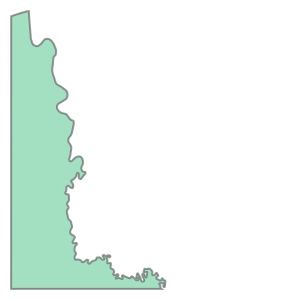

In [368]:
shape_region_cut

In [369]:
gs_aoi2 = gpd.GeoSeries([shape_region_cut]) #or gpd.GeoDataFrame([shape(geojson_lcc2)]) ??

In [370]:
gd_aoi2 = gpd.GeoDataFrame()

In [371]:
gd_aoi2['geometry'] = gs_aoi2

In [372]:
gd_aoi2

,geometry
0,"POLYGON ((3328376.588 713413.301, 3328382.303 ..."


In [373]:
gdf_df_join_intersects_aoi2 = gpd.sjoin(gdf_df_join.reset_index(drop=True),
                                       gd_aoi2.reset_index(drop=True),
                                       op='intersects',
                                       how='inner')

In [377]:
len(gdf_df_join.index)

451947

In [378]:
len(gdf_df_join_intersects_aoi2.index)

73032

In [379]:
gdf_df_join_intersects_aoi2.head()

,geometry,features_id,ndvi_2018-10-31,gndvi_2018-10-31,avi_2018-10-31,ndvi_2018-11-30,gndvi_2018-11-30,avi_2018-11-30,ndvi_2018-12-31,gndvi_2018-12-31,...,ndvi_2019-07-31,gndvi_2019-07-31,avi_2019-07-31,ndvi_2019-08-31,gndvi_2019-08-31,avi_2019-08-31,ndvi_2019-09-30,gndvi_2019-09-30,avi_2019-09-30,index_right
106602,"POLYGON ((3330680.000 714220.000, 3330690.000 ...",345111,-1718.061674,-1578.947368,314.631587,-1084.689450,-745.445749,281.189160,42.859522,673.376881,...,-1426.669339,-2227.036551,402.171495,-2275.268807,-2583.345291,384.696727,3245.268934,2683.181833,NaN,0
106861,"POLYGON ((3330690.000 714180.000, 3330700.000 ...",345109,NaN,NaN,NaN,4097.735425,3829.842510,254.401132,5952.087281,5512.734940,...,3401.260075,2152.282026,NaN,4138.906185,3190.445923,NaN,3638.771296,3047.341324,NaN,0
106862,"POLYGON ((3330700.000 714180.000, 3330710.000 ...",345110,NaN,NaN,NaN,297.479438,381.040098,275.252168,3582.615637,3621.355933,...,-105.443894,-987.794857,356.913930,-752.716786,-1210.661636,366.205511,3368.020835,2724.622318,NaN,0
107016,"POLYGON ((3330640.000 714230.000, 3330670.000 ...",344752,5975.876903,4708.158635,NaN,6949.993983,5952.687165,274.091503,8212.518045,7355.810814,...,6007.203756,5009.506609,NaN,6835.063828,5712.812532,NaN,3869.042340,3283.142348,NaN,0
107064,"POLYGON ((3330730.000 714180.000, 3330750.000 ...",344418,1160.409556,672.975815,239.241354,-1714.876658,-1318.561452,271.925801,-1469.257268,-860.765370,...,-1396.139050,-2041.969662,461.546632,-2027.626737,-2302.202083,528.392558,3257.746461,2609.647694,NaN,0


# 5) Unsupervised clustering with Kmeans

**Número de clústers depende del número de cultivos presentes en el dc_tile** 

**Revisar credenciales de db**

In [195]:
var[1].geobox.geographic_extent.json

{'type': 'Polygon',
 'coordinates': [[(-94.15122923779683, 18.283423396251024),
   (-94.1770621971074, 17.834324723281572),
   (-93.70555365678503, 17.80907660608144),
   (-93.67817046279085, 18.25807326733729),
   (-94.15122923779683, 18.283423396251024)]]}

In [187]:
training_set = 'cultivos2019_inecol'

In [188]:
qs = TrainClassification.objects.filter(train_object__the_geom__contained=geom,
                                        training_set=training_set).prefetch_related('interpret_tag')

In [189]:
l_tag_ids = []

In [190]:
for element in qs:
    l_tag_ids.append(element.interpret_tag.id)

In [191]:
nclusters = len(np.unique(l_tag_ids))

In [192]:
nclusters

0

In [391]:
nclusters=3

In [392]:
kmeans = KMeans(n_clusters=nclusters, n_jobs=10)

In [393]:
features_for_kmeans = [column for column in list(gdf_df_join_intersects_aoi2.columns) if column not in ['geometry','features_id']]

In [394]:
len(features_for_kmeans)

37

In [395]:
kmeans.fit(gdf_df_join_intersects_aoi2[features_for_kmeans].fillna(0).values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=10, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

**Write model fit**

In [400]:
model_filename = path_result_dc_tile + date_today + '_model_' +  dc_tile + '_nclusters_%d' % nclusters + '_aoi' + '.pkl'

In [401]:
model_filename

'/LUSTRE/MADMEX/tasks/2020/1_clusterization_for_agriculture_labeling/features_computed/ndvi-gndvi-avi/02-13-2020/47_-35/02-13-2020_model_47_-35_nclusters_3_aoi.pkl'

In [402]:
pickle.dump(kmeans, open(model_filename, "wb"))

**Predict with model**

In [403]:
model_filename = path_result_dc_tile + date_today + '_model_' +  dc_tile + '_nclusters_%d' % nclusters + '_aoi' + '.pkl'

In [404]:
model_filename

'/LUSTRE/MADMEX/tasks/2020/1_clusterization_for_agriculture_labeling/features_computed/ndvi-gndvi-avi/02-13-2020/47_-35/02-13-2020_model_47_-35_nclusters_3_aoi.pkl'

In [405]:
kmeans = pickle.load(open(model_filename, "rb"))

**Predict**

In [406]:
preds = kmeans.predict(gdf_df_join_intersects_aoi2[features_for_kmeans].fillna(0).values)

In [407]:
preds

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [408]:
gdf_df_clusters = gdf_df_join_intersects_aoi2.drop(features_for_kmeans,axis=1)

In [409]:
gdf_df_clusters.head()

,geometry,features_id
106602,"POLYGON ((3330680.000 714220.000, 3330690.000 ...",345111
106861,"POLYGON ((3330690.000 714180.000, 3330700.000 ...",345109
106862,"POLYGON ((3330700.000 714180.000, 3330710.000 ...",345110
107016,"POLYGON ((3330640.000 714230.000, 3330670.000 ...",344752
107064,"POLYGON ((3330730.000 714180.000, 3330750.000 ...",344418


In [410]:
gdf_df_clusters['preds'] = preds

In [411]:
gdf_df_clusters.head()

,geometry,features_id,preds
106602,"POLYGON ((3330680.000 714220.000, 3330690.000 ...",345111,1
106861,"POLYGON ((3330690.000 714180.000, 3330700.000 ...",345109,1
106862,"POLYGON ((3330700.000 714180.000, 3330710.000 ...",345110,1
107016,"POLYGON ((3330640.000 714230.000, 3330670.000 ...",344752,0
107064,"POLYGON ((3330730.000 714180.000, 3330750.000 ...",344418,1


In [412]:
len(gdf_df_clusters.index)

73032

# 6) Write results to file

**Geopackage**

In [413]:
path_results_geopackage = '/home/madmex_user/agriculture_geopackages/features_computed/' + features_string + '/'

In [414]:
path_results_geopackage

'/home/madmex_user/agriculture_geopackages/features_computed/ndvi-gndvi-avi/'

In [415]:
path_result_geopackage = os.path.join(path_results_geopackage, date_today 
                                       + '/' + dc_tile + '/')

In [416]:
path_result_geopackage

'/home/madmex_user/agriculture_geopackages/features_computed/ndvi-gndvi-avi/02-13-2020/47_-35/'

In [417]:
if not os.path.exists(path_result_geopackage):
    os.makedirs(path_result_geopackage)

In [420]:
clusters_filename = path_result_geopackage + date_today + '_clusters_' +  dc_tile + '_nclusters_%d' % nclusters + '_aoi' + '.gpkg'

In [421]:
clusters_filename

'/home/madmex_user/agriculture_geopackages/features_computed/ndvi-gndvi-avi/02-13-2020/47_-35/02-13-2020_clusters_47_-35_nclusters_3_aoi.gpkg'

In [422]:
layer_name = date_today + '_clusters_' +  dc_tile + '_nclusters_%d' % nclusters + '_aoi'

In [423]:
layer_name

'02-13-2020_clusters_47_-35_nclusters_3_aoi'

In [424]:
gdf_df_clusters.crs

{'proj': 'lcc',
 'lat_1': 17.5,
 'lat_2': 29.5,
 'lat_0': 12,
 'lon_0': -102,
 'x_0': 2500000,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True,
 'wktext': True}

In [425]:
crs_dict

{'proj': 'lcc',
 'lat_1': 17.5,
 'lat_2': 29.5,
 'lat_0': 12,
 'lon_0': -102,
 'x_0': 2500000,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True,
 'wktext': True}

In [426]:
start_time=time.time()

gdf_df_clusters.to_file(clusters_filename,
                        layer=layer_name,
                        driver='GPKG')
end_time=time.time()

In [427]:
secs = end_time-start_time
secs

27.65104031562805

In [428]:
shutil.move(clusters_filename,path_result_dc_tile)

'/LUSTRE/MADMEX/tasks/2020/1_clusterization_for_agriculture_labeling/features_computed/ndvi-gndvi-avi/02-13-2020/47_-35/02-13-2020_clusters_47_-35_nclusters_3_aoi.gpkg'

**Shapefile**

In [431]:
clusters_filename = path_result_dc_tile + date_today + '_clusters_' +  dc_tile + '_nclusters_%d' % nclusters + '_aoi' + '.shp'

In [432]:
clusters_filename

'/LUSTRE/MADMEX/tasks/2020/1_clusterization_for_agriculture_labeling/features_computed/ndvi-gndvi-avi/02-13-2020/47_-35/02-13-2020_clusters_47_-35_nclusters_3_aoi.shp'

In [433]:
gdf_df_clusters.crs

{'proj': 'lcc',
 'lat_1': 17.5,
 'lat_2': 29.5,
 'lat_0': 12,
 'lon_0': -102,
 'x_0': 2500000,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True,
 'wktext': True}

In [434]:
start_time=time.time()
gdf_df_clusters.to_file(clusters_filename)
end_time=time.time()

In [435]:
secs = end_time-start_time
secs

44.49738430976868